In [1]:
# import packages

import matplotlib.animation as animation
import time
import importlib
import sys
import pickle
import pandas as pd
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import norm
from scipy import stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 34})
import sys
import scipy
import os
from importlib import reload

PATH = '../codes/'
sys.path.insert(1,PATH)

vcol =['rosybrown','red','darkseagreen','orange','blueviolet','lawngreen','fuchsia','cyan','darkolivegreen','black','deepskyblue','lightslategray','darkslateblue','sienna','darkgoldenrod','olive']

import IAE_CNN_TORCH_Oct2023 as cnn
from model_selection_variability import BCD,model_selection,POMP
import model_selection_variability

from general import normalize,normalize4, divergence, NNPU, NMF_divergence,index_array_3D,list_array
from uncertainty import *


C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Read data

In [2]:

def read_spectrum(fname):
    spec = []
    for line in open(fname, 'r'):
        spec.append(float(line.rstrip()))
    return np.array(spec)


def GetListData(name=0):
    PATH_DATA=os.path.join('../data/Simulation_steel_sphere', RN_NAME[name])
    list_thickness=[]
    list_data=[]

    for file in os.listdir(PATH_DATA):
        if file.endswith(".dat"):
            tmp_file=os.path.join(PATH_DATA, file)
            list_data+=[tmp_file]
    ## list thickness
    ## replace __ = . , (2__0=2.0mm)
    for tmp_file in list_data:
        pos=tmp_file.find("STEEL")
        tmp_thick=tmp_file.replace(tmp_file[:pos+5],"")
        tmp=tmp_thick.replace("mm.dat","")
        if "__" in tmp:
            tmp=tmp.replace("__",".")
        list_thickness+=[float(tmp)]
    ##sort data 
    ind=np.argsort(list_thickness)
    list_thickness=np.sort(list_thickness)
    list_data = [list_data[i] for i in ind]

    return list_data,list_thickness


def GetSpectra(name=0):
    list_data,list_thickness=GetListData(name)
    spec=[]
    for i in range(len(list_data)):
        spec += [read_spectrum(list_data[i])]
    spec=np.array(spec).T
    # cut 20kev 
    # 1024 channels, 1 channel=2kev
    spec = spec[20:2048+20,:]
    spec=spec[0::2,:]+spec[1::2,:]
    ## channel>max channel: value =0
    spec[max_channel_list[name]:,:]=0
    ## Am241 with high thicknesses, spectral signatures are almost absored by attenuation 
    ## X of Am241 for thickness >4 mm = X of 4 mm  
    if name==5:
        spec[:,30:]=spec[:,29:30].dot(np.ones((1,spec.shape[1]-30)))
    
    return spec.T,list_thickness

## Load pre-trained IAE models

In [3]:
# joint model
fname='./Models/IAE_CNN_12radio_40data'
model=cnn.load_model(fname)
model.nneg_output=True

## Define spectral signature X using thickness

In [4]:
# Initiazation matrix X from thickness
def init_X(XMVP,position):
    # position: position of thickness used to create X
    Xtmp=spec_list[position].squeeze()
    Xtmp=(np.concatenate([XMVP,Xtmp],axis=1))
    return Xtmp

## MVP  (Natural Background (Bkg))

In [5]:
MVP=read_spectrum('../data/SPS_NaITl_3pouces_Exp_1keVCanal_Max2200keV_#20012023A.txt')
MVP=MVP[20:2048+20]
MVP=MVP[0::2]+MVP[1::2]
MVP=MVP[:]
## avoid zeros for Bkg
MVP[:2]=1/10*min(MVP[2:])
XMVP=MVP/np.sum(MVP)
XMVP=XMVP[:,np.newaxis]

# Create a gamma-simulation

In [6]:
RN_NAME=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','Y88','Bi207','I123','I131','Tc99m','Ga67']
max_channel_list=np.array([800,250,100,400,900,50,1024,800,100,500,100,250]) # max energy for each radionuclide
norm='1'# normalizing norm
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name)
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)
spec_list=normalize4(spec_list[:,:,:],opt=norm)

In [7]:
position_exact=70# thickness
counting=2500 # total counting
coef=np.array([0.5,0.15,0 ,0 ,0.1,0 ,0 , 0.15,0,0,0,0.1,0]) # mixing weights
#coef=np.array([0.5,0,0.3 ,0 ,0.2,0 ,0 , 0,0,0,0,0,0])

########################
X=init_X(XMVP,position_exact)    
X0=init_X(XMVP,0) # init thickness: 0.001 mm
radio=coef>0
nbr_step=len(coef[radio])
name_label=['Bkg']+ RN_NAME
list_radio=np.arange(len(name_label))[radio]
list_radio2=np.arange(len(coef)-1)[coef[1:]>0]

print('Thickness: ',list_thickness[position_exact])
print('Radio: ',['Bkg']+RN_NAME)
print('Expected counting: ',counting*coef)

print(list_radio)
print(np.array(name_label)[radio])

Thickness:  20.1
Radio:  ['Bkg', 'Co60', 'Ba133', 'Co57', 'Cs137', 'Eu152', 'Am241', 'Y88', 'Bi207', 'I123', 'I131', 'Tc99m', 'Ga67']
Expected counting:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
[ 0  1  4  7 11]
['Bkg' 'Co60' 'Cs137' 'Y88' 'Tc99m']


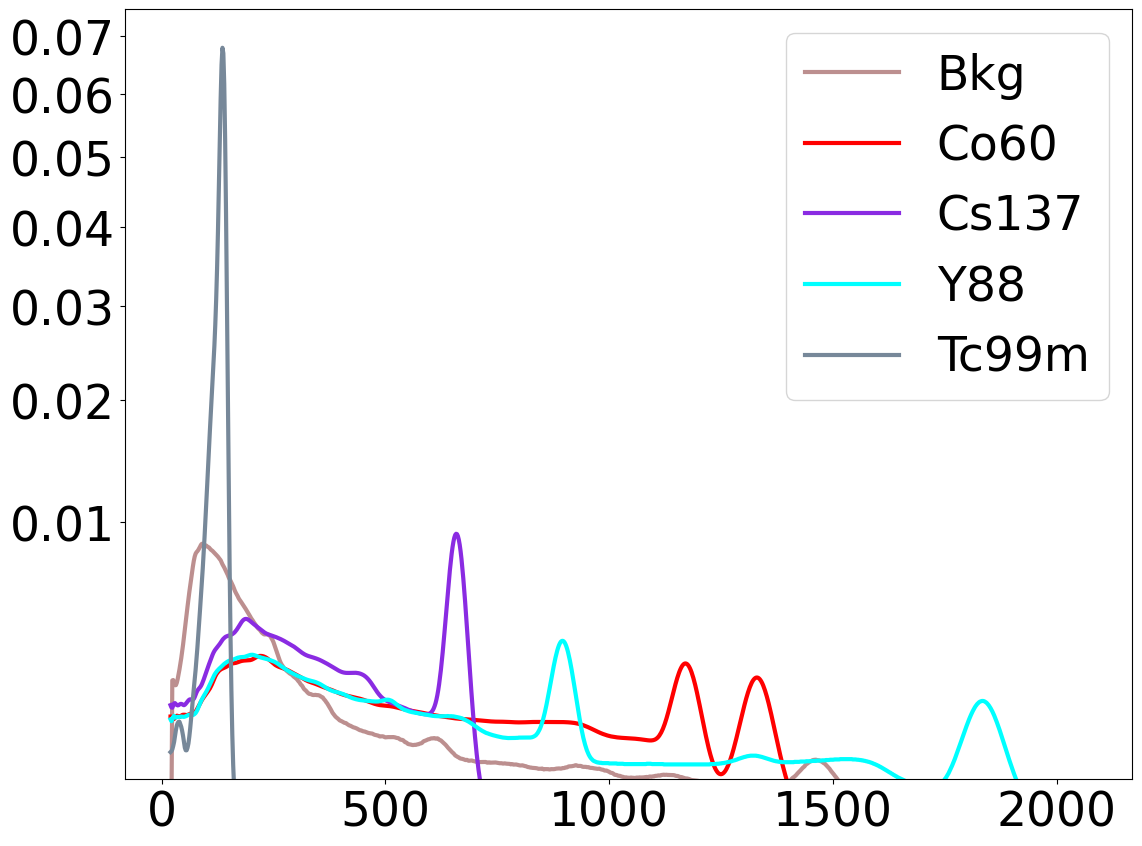

In [8]:
color_list=vcol
name_label=['Bkg']+ RN_NAME
plt.figure(figsize=(13,10))
enr=(np.arange(1024)*2+20) 
list_radio_plot=list(list_radio)
for i in range(len(list_radio_plot)):
    plt.plot(enr,X[:,list_radio_plot[i]],label=name_label[list_radio_plot[i]],lw=3,color=color_list[list_radio_plot[i]])
plt.legend()
f = lambda a: a**(1/2)
g = lambda a: a**2
plt.yscale('function', functions=(f,g))

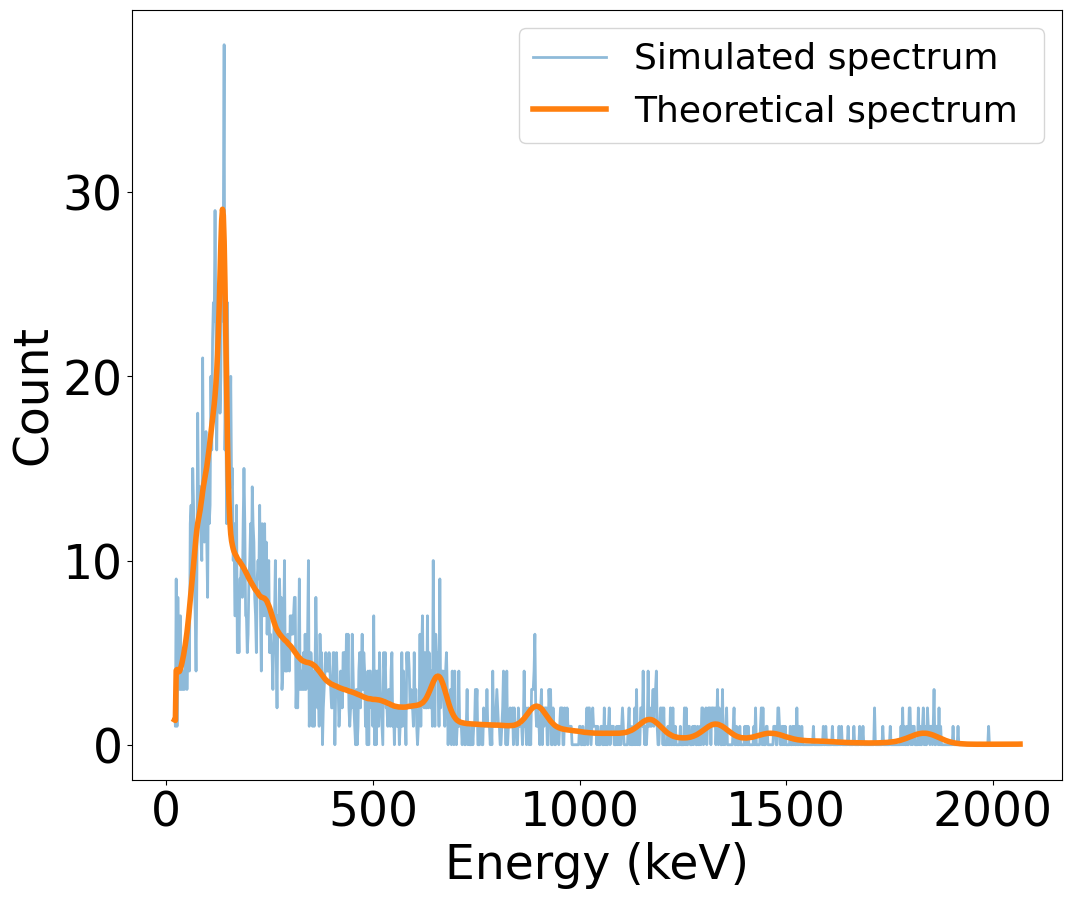

In [9]:
M,N=np.shape(X)
a=counting*coef
lamb=X.dot(a) # Poisson parameter
np.random.seed(0)
y=np.random.poisson(lamb) 
a0=np.sum(lamb)/len(a)*np.ones((len(a))) # initial value of a
enr=(np.arange(1024)*2+20)/100*100    
plt.figure(figsize=(12,10))
plt.plot(enr,y,lw=2,alpha=0.5,label='Simulated spectrum')
plt.plot(enr,lamb,lw=4,label='Theoretical spectrum ')
plt.xlabel('Energy (keV)')
plt.ylabel('Count')
plt.legend(fontsize=26)

# NNPU: known spectral signatures and active radionuclides

In [10]:
t1=time.time()
res_nnpu=NNPU(y,X[:,radio])
std_nnpu=std_fisher(X[:,radio],res_nnpu)
print('Expected: ',a)
print('Estimated counting:',res_nnpu)
print('Uncertainty: (std)',std_nnpu)

print('time: ',time.time()-t1)


Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Estimated counting: [1225.07006036  404.08261201  308.88165094  380.64232606  229.32335064]
Uncertainty: (std) [74.33453678 52.50810333 45.9619419  53.64090884 27.56218816]
time:  0.010718584060668945


# P-OMP: known spectral signatures and unknown active radionuclides 

In [11]:
t1=time.time()
res_pomp=POMP(y,X,1/100,turn=2)
std_pomp=std_fisher(X,res_pomp['a'])

print('Expected: ',a)
print('Estimated counting:',np.round(res_pomp['a']))
print('Uncertainty: (std)',np.round(std_pomp))
print('Identified radionuclides: ',res_pomp['Iden'])
print('Selection procedure: ',res_pomp['Procedure']) # switch to a mixture of Ba133 and Cs137 to see the difference
print('time: ',time.time()-t1)


Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Estimated counting: [1225.  404.    0.    0.  309.    0.    0.  381.    0.    0.    0.  229.
    0.]
Uncertainty: (std) [74. 53.  0.  0. 46.  0.  0. 54.  0.  0.  0. 28.  0.]
Identified radionuclides:  [0, 7, 1, 11, 4]
Selection procedure:  [0, 7, 1, 11, 4]
time:  3.0220608711242676


# SEMSEUN: unknown spectral signatures and known active radionuclides

In [12]:
t1=time.time()
# X is optional, can be None, just to calculate NMSE of estimated X

res_semsun=BCD(y,X0,a0,X=None,list_model=[model],estimed_aMVP=1,tol_BSP=1e-8,
        tol=1e-4,niter_max_out=30,niter_max_BSP=100,step_size_BSP=1e-4,optim=0,radio=radio)
std_semsun=get_std_autograd(res_semsun[1],res_semsun[4],y,model,XMVP,max_channel_list)
print('time: ',time.time()-t1)

time:  4.676239490509033


In [13]:
print('Expected: ',a)
print('Identified radionuclides: ',np.round(res_semsun[1]))
print('Uncertainty: (std)',np.round(std_semsun[:-1]))


Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Identified radionuclides:  [1224.  407.    0.    0.  309.    0.    0.  379.    0.    0.    0.  229.
    0.]
Uncertainty: (std) [88. 54.  0.  0. 46.  0.  0. 54.  0.  0.  0. 28.  0.]


# MoSeVa: spectral unmixing with spectral variability

In [14]:
t1=time.time()
alpha=1/100 # expected false positive rate
# X is optional,can be None, just to calculate NMSE of estimated X
#a0_i =0 inital counting of radionuclide i =0 -> tested dictionary doesnot contain this radionuclide
res_moseva=model_selection(y,X0,a0,X=None,list_model=[model],estimed_aMVP=1,tol_BSP=1e-8,
        tol=1e-4,niter_max_out=30,niter_max_BSP=100,step_size_BSP=1e-4,optim=0,turn=2,alpha=alpha)
std_moseva=get_std_autograd(res_moseva['Quan'][1],res_moseva['LambdaList'][-1],y,model,XMVP,max_channel_list)

print('time: ',time.time()-t1)

[0, 7]
[0, 7, 1]
[0, 7, 1, 11]
[0, 7, 1, 11, 4]
time:  87.65289330482483


In [15]:
print('Expected: ',a)
print('Identified radionuclides: ',res_moseva['Iden'])
print('Estimated counting: ',np.round(res_moseva['Quan'][1]))
print('Uncertainty: (std)',np.round(std_moseva[:-1]))
print('Estimated lambda: ',res_moseva['LambdaList'][-1])
#print('Selection procedure: ',res_moseva['Procedure'])

Expected:  [1250.  375.    0.    0.  250.    0.    0.  375.    0.    0.    0.  250.
    0.]
Identified radionuclides:  [0, 7, 1, 11, 4]
Estimated counting:  [1222.  408.    0.    0.  309.    0.    0.  379.    0.    0.    0.  230.
    0.]
Uncertainty: (std) [88. 54.  0.  0. 46.  0.  0. 55.  0.  0.  0. 28.  0.]
Estimated lambda:  [0.11934377 0.88065623]


# MCMC

In [16]:
import uncertainty
importlib.reload(uncertainty)
from uncertainty import *

In [17]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS,HMC
import logging
logging.basicConfig(format="%(message)s", level=logging.INFO)
pyro.set_rng_seed(0)

## MCMC for known X and actives radionuclides

In [18]:
num_samples=1000 # number of samples
warmup_steps=300 
min_counting_radio=0
# init condition for a and lambda
cond=[[1e3,1e6],[[0.2,0.1,0.1,0.1,0.1],[0.8,1.0,1.0,1.0,1.0]],[0,96]]
condition2=cond.copy()
condition2[2]=[0.0,1.0]## lambda [0,1] for mcmc

In [19]:
data=torch.tensor( y.astype("float32"))
MVP_tensor=torch.tensor( XMVP.astype("float32"))
XRec=torch.tensor( X[:,1:].astype("float32"))
XRec=XRec[:,list_radio2]

In [20]:
pyro.clear_param_store()
nuts_kernel = NUTS(model_mcmc_Xfixed,step_size=2 ,adapt_step_size=True,max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps,num_chains=1 )
mcmc.run(list_radio2,data,XRec,MVP_tensor,condition2[:2],min_counting_radio)
res_mcmc_Xfixed=[]
res_mcmc_Xfixed+=[mcmc.get_samples()['a_Bkg'][:,0].detach().numpy()*np.sum(y)]
for i in range(len(list_radio2)):
    res_mcmc_Xfixed+=[mcmc.get_samples()[f"a_{i+1}"][:,0].detach().numpy()*np.sum(y)]
res_mcmc_Xfixed=np.array(res_mcmc_Xfixed).T

Sample: 100%|███████████████████████████████████████| 1300/1300 [00:16, 76.98it/s, step size=3.98e-01, acc. prob=0.936]


## MCMC for unknown X and known actives radionuclides

In [23]:
pyro.clear_param_store()
nuts_kernel = NUTS(model_mcmc,step_size=2 ,adapt_step_size=True,max_tree_depth=10)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps,num_chains=1 )
mcmc.run(list_radio2,data,model,MVP_tensor,max_channel_list,condition2,min_counting_radio)
res_mcmc=[]
res_mcmc+=[mcmc.get_samples()['a_Bkg'][:,0].detach().numpy()*np.sum(y)]
for i in range(len(list_radio2)):
    res_mcmc+=[mcmc.get_samples()[f"a_{i+1}"][:,0].detach().numpy()*np.sum(y)]
res_mcmc+=[mcmc.get_samples()['lambda'][:,0].detach().numpy()]
res_mcmc=np.array(res_mcmc).T

Sample: 100%|███████████████████████████████████████| 1300/1300 [05:48,  3.73it/s, step size=4.25e-01, acc. prob=0.903]


# Resultat of LA, MCMC

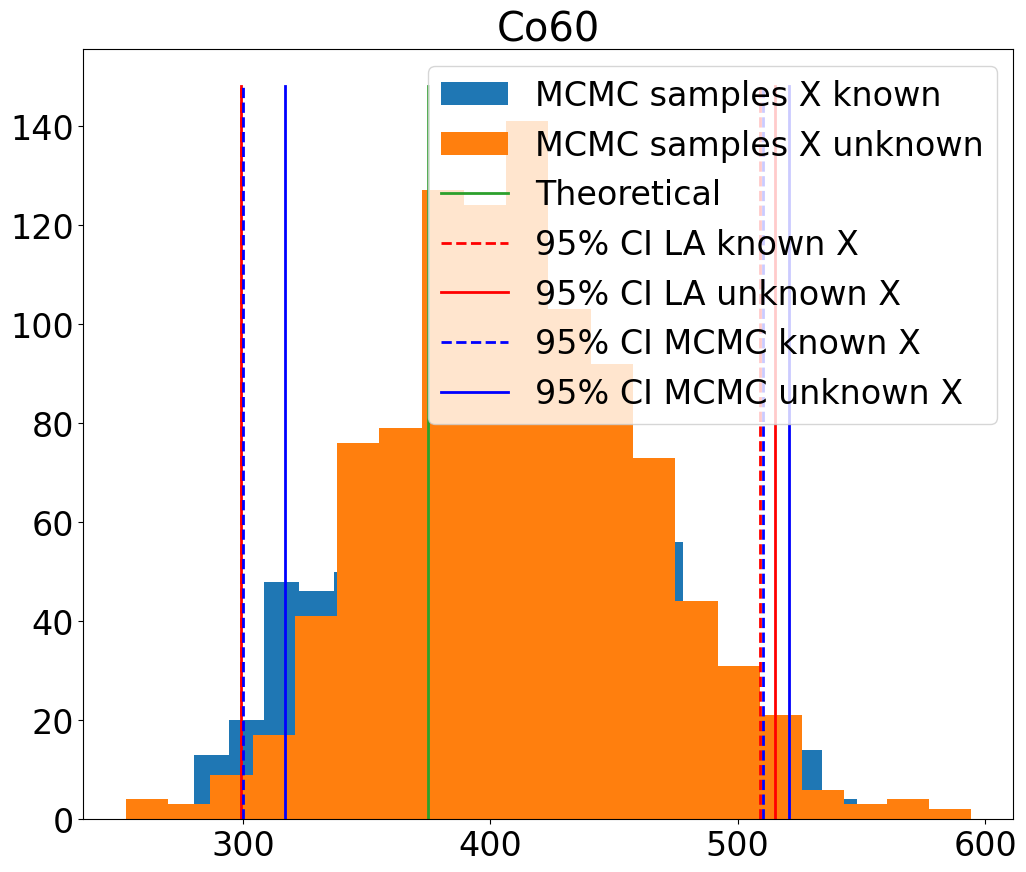

In [24]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(12,10))
i=1 # radionuclide
k=0 # coverage level
label_name=['95','99.7']
cri_mcmc=get_optimal_coverage_interval(res_mcmc_Xfixed[np.newaxis,:,:],np.array([95.4,99.7])/100)
plt.hist(res_mcmc_Xfixed[:,i],bins=20,label='MCMC samples X known')

plt.hist(res_mcmc[:,i],bins=20,label='MCMC samples X unknown')
cri_mcmc2=get_optimal_coverage_interval(res_mcmc[np.newaxis,:,:],np.array([95.4,99.7])/100)


ylim=plt.gca().get_ylim()
plt.plot(a[list_radio[i]]*np.ones(100),np.linspace(ylim[0],ylim[1],100),lw=2,label='Theoretical')
plt.plot((res_nnpu[i]+(k+2)*std_nnpu[i])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'--',lw=2,label=label_name[k]+ '% CI LA known X',color='r')
plt.plot((res_nnpu[i]-(k+2)*std_nnpu[i])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'--',lw=2,color='r')
plt.plot((res_semsun[1][list_radio[i]]+(k+2)*std_semsun[list_radio[i]])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'-',lw=2,label=label_name[k]+ '% CI LA unknown X',color='r')
plt.plot((res_semsun[1][list_radio[i]]-(k+2)*std_semsun[list_radio[i]])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'-',lw=2,color='r')
plt.plot((cri_mcmc[k,0,i,0])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'--',lw=2,label=label_name[k]+'% CI MCMC known X',color='b')
plt.plot((cri_mcmc[k,0,i,1])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'--',lw=2,color='b')
plt.plot((cri_mcmc2[k,0,i,0])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'-',lw=2,label=label_name[k]+'% CI MCMC unknown X ',color='b')
plt.plot((cri_mcmc2[k,0,i,1])*np.ones(100),np.linspace(ylim[0],ylim[1],100),'-',lw=2,color='b')
plt.title(np.array(['Bkg']+RN_NAME)[list_radio[i]])
plt.legend()  
plt.rcParams.update({'font.size': 34})
